In [43]:
# Autor: Mario
# Propósito del código: Realizar un modelo de regresion logistica
# Descripción y uso: Primero se realiza la lectura de datos, luego realizo una seleccion de variables dejando solo las mas influyentes en el modelo y
#  evitando correlaciones (columnas innecesarias), para finalmente realizar un ajuste de hiperparametros y obtener un modelo el cual es evaluamos.
# Estado actual: En proceso (Estoy viendo si es posible mejorar la seleccion de variables y alguna cosilla más)

In [44]:
#NO BORRAR ESTA CELDA!!!!!!!!!!!!!!!!

#Marca con un * al final las que ya estén solucionadas

#Solucionar:
#Hacer lectura de las particiones ya hechas en drive*
#No hay estudio de transformaciones: explica cuales haces y porque*
#Se evaluan los modelos con accuracy en vez de f1-score (se explica el porque en la memoria)*
#No hay estudio de selección de variables. Si es necesario hacer una selección indicar que algoritmo de selección de variables usar.*
#Porque son innecesarias las columnas que eliminas?*

*Importo librerias necesarias*

In [ ]:
import os
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, log_loss,confusion_matrix,make_scorer,f1_score
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import StratifiedKFold,GridSearchCV,RandomizedSearchCV
from sklearn.feature_selection import RFECV
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import uniform

Lectura de ficheros

In [4]:
rutaTrain = os.path.join(os.getcwd(), "..", "..","..", "data", "P1", "train.parquet")
rutaVal = os.path.join(os.getcwd(), "..", "..","..", "data", "P1", "validation.parquet")
rutaTest = os.path.join(os.getcwd(), "..", "..","..", "data", "P1", "test.parquet")
train = pd.read_parquet(rutaTrain)
val = pd.read_parquet(rutaVal)
test = pd.read_parquet(rutaTest)
print(f'Train: {train.shape}')
print(f'Validation: {val.shape}')
print(f'Test: {test.shape}')

Train: (5490, 84)
Validation: (1177, 84)
Test: (1177, 84)


Elimino columnas innecesarias

In [5]:
train = train.drop(columns=["DATE","CATEGORY","METHOD","Peleador_A","Peleador_B",'TITLE_FIGHT', 'WOMEN'])
val = val.drop(columns=["DATE","CATEGORY","METHOD","Peleador_A","Peleador_B",'TITLE_FIGHT', 'WOMEN'])
test = test.drop(columns=["DATE","CATEGORY","METHOD","Peleador_A","Peleador_B",'TITLE_FIGHT', 'WOMEN'])

Separo en X e Y

In [6]:
train_x=train.drop(columns='WINNER')
train_y=train['WINNER']
val_x=train.drop(columns='WINNER')
val_y=train['WINNER']
test_x=train.drop(columns='WINNER')
test_y=train['WINNER']

Tratamiento de correlaciones

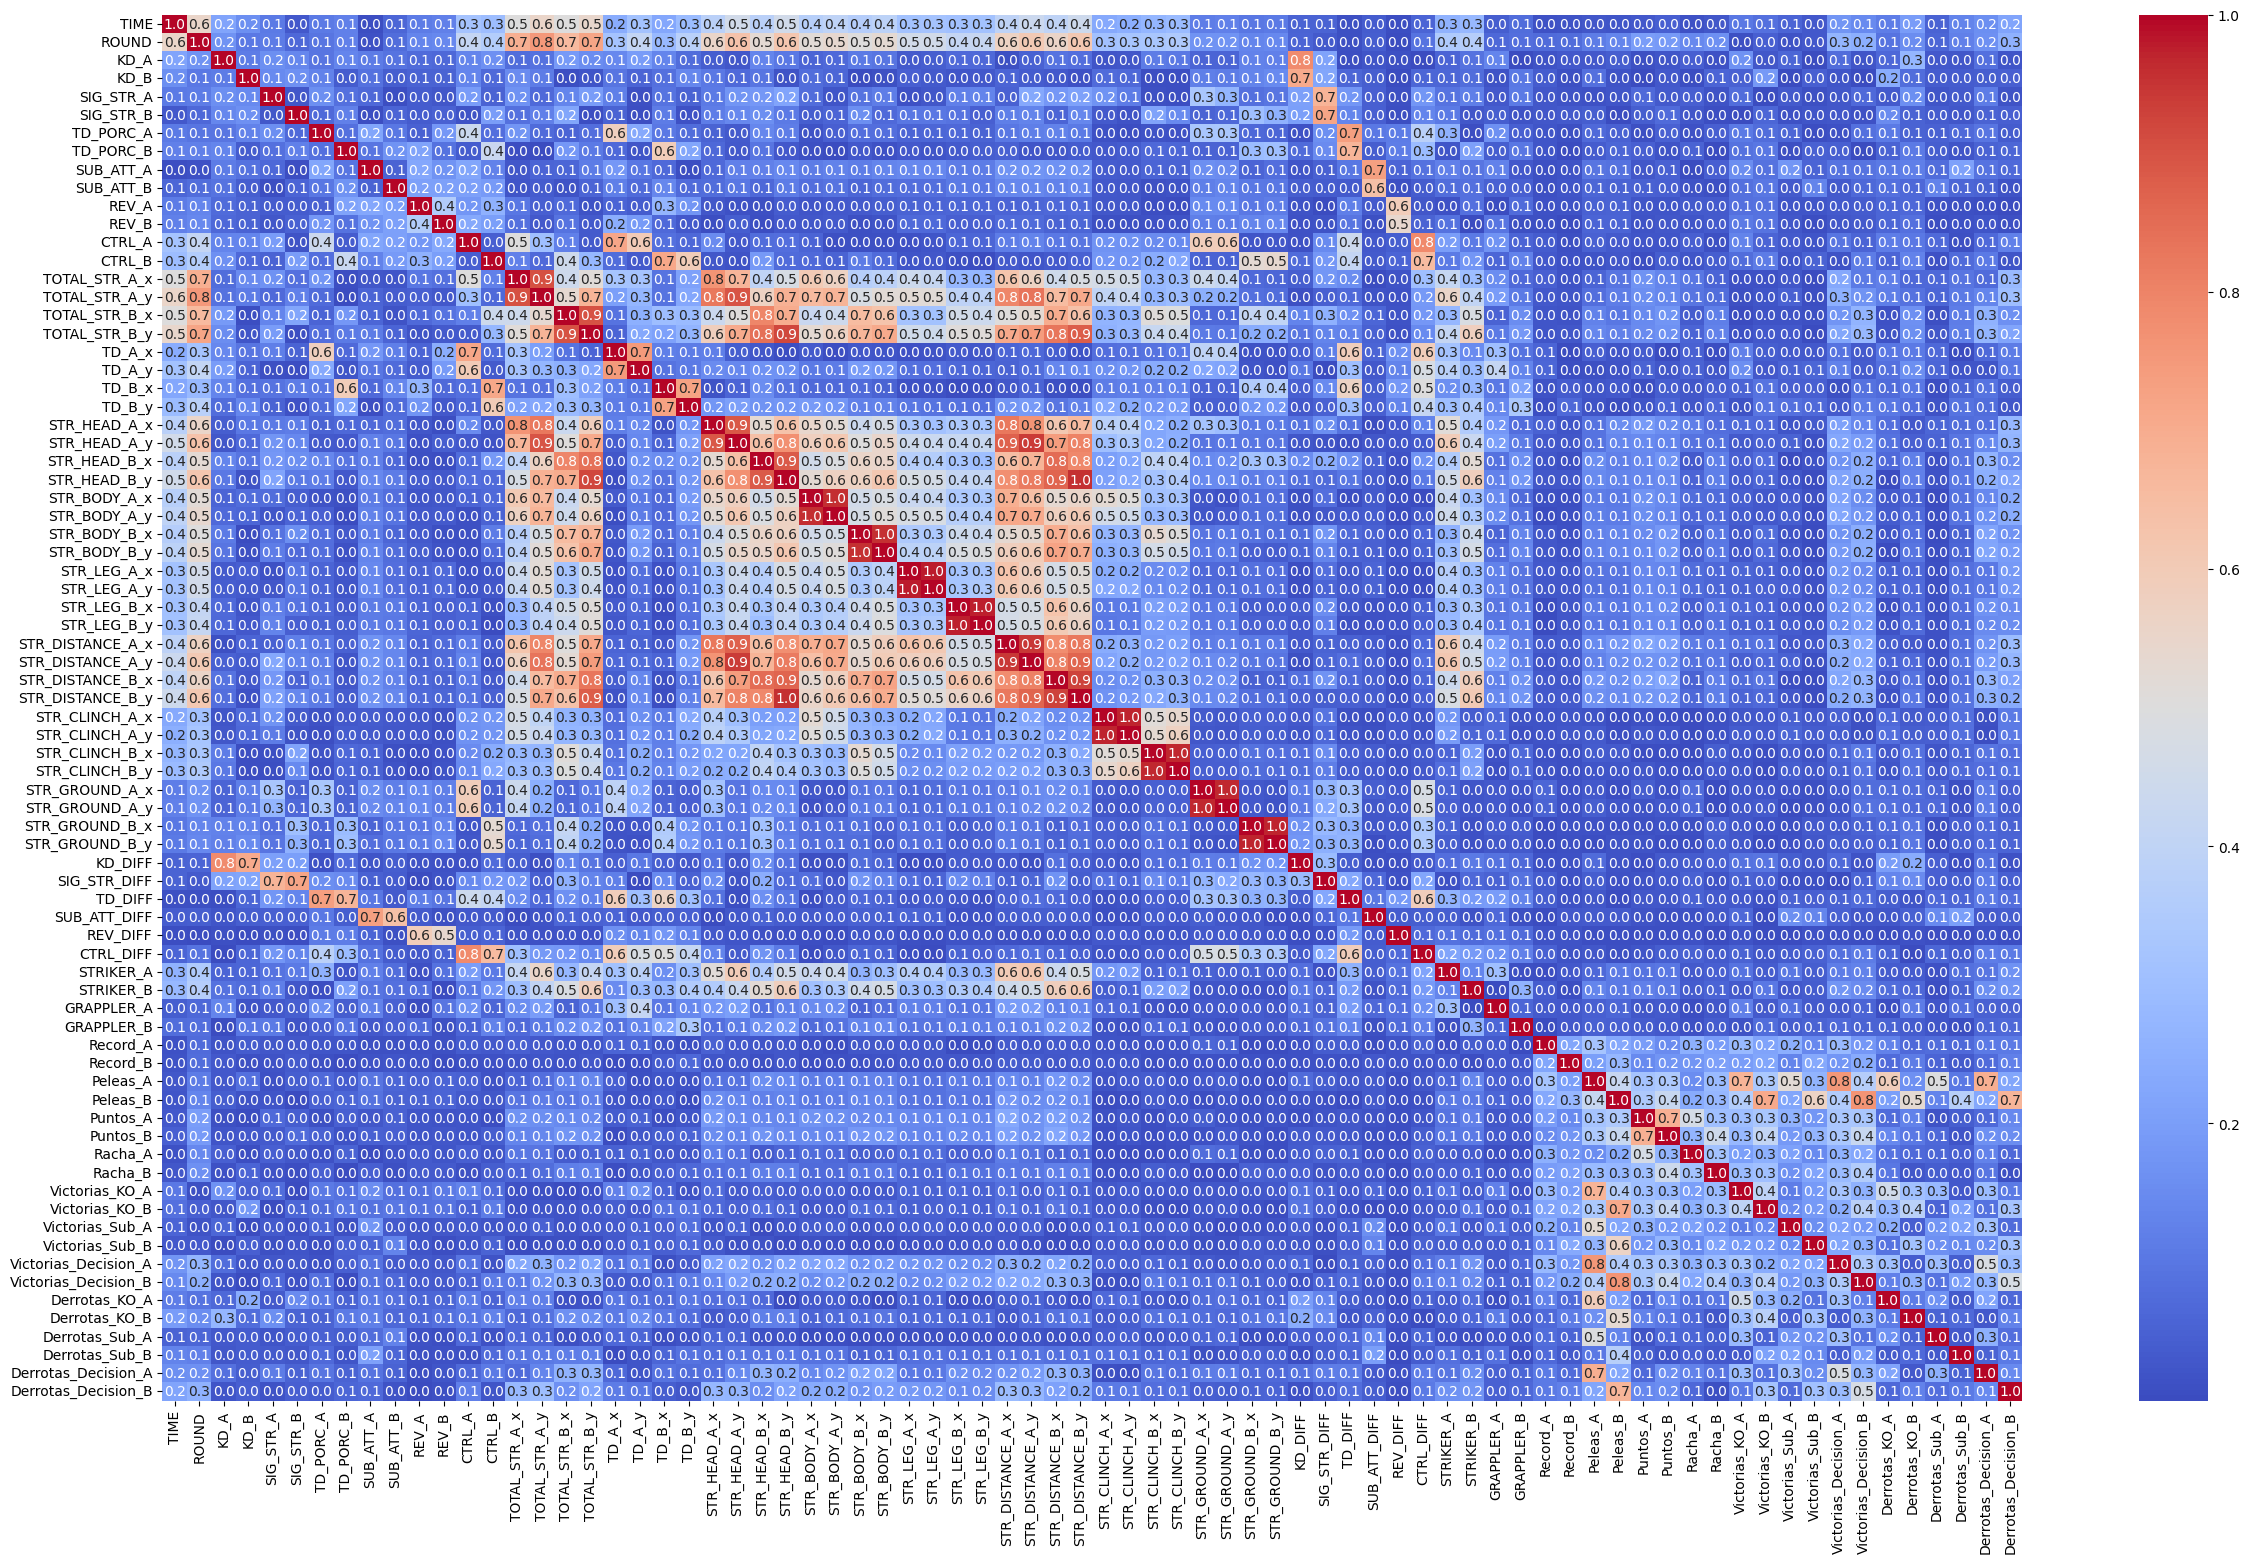

In [10]:
#Muestro correlaciones entre variables

plt.figure(figsize=(30, 18))
sns.heatmap(train_x.corr().abs(), annot=True, cmap="coolwarm", fmt=".1f")
plt.show()

In [7]:
# Calculo la matriz de correlación con spearman ya que variables no siguen una distribucion normal
correlation_matrix = train_x.corr(method='spearman')

umbral = 0.79
#Obtengo pares de variables con alta correlación (excluyendo la diagonal)
correlated_features = (
    correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))
    .stack()
    .reset_index()
)

# Filtrar pares con correlación mayor al umbral
correlated_features.columns = ["Variable 1", "Variable 2", "Correlación"]
highly_correlated = correlated_features[abs(correlated_features["Correlación"]) > umbral]

print("Variables altamente correlacionadas:\n", highly_correlated)


Variables altamente correlacionadas:
             Variable 1        Variable 2  Correlación
88               ROUND     TOTAL_STR_A_y     0.802468
192               KD_A           KD_DIFF     0.793400
446          TD_PORC_A            TD_A_x     0.874402
516          TD_PORC_B            TD_B_x     0.922550
959      TOTAL_STR_A_x     TOTAL_STR_A_y     0.937687
966      TOTAL_STR_A_x      STR_HEAD_A_x     0.820151
1026     TOTAL_STR_A_y      STR_HEAD_A_x     0.850698
1027     TOTAL_STR_A_y      STR_HEAD_A_y     0.912430
1038     TOTAL_STR_A_y  STR_DISTANCE_A_x     0.792163
1039     TOTAL_STR_A_y  STR_DISTANCE_A_y     0.824552
1080     TOTAL_STR_B_x     TOTAL_STR_B_y     0.934115
1087     TOTAL_STR_B_x      STR_HEAD_B_x     0.844549
1088     TOTAL_STR_B_x      STR_HEAD_B_y     0.791203
1145     TOTAL_STR_B_y      STR_HEAD_B_x     0.873005
1146     TOTAL_STR_B_y      STR_HEAD_B_y     0.931890
1156     TOTAL_STR_B_y  STR_DISTANCE_A_y     0.802379
1157     TOTAL_STR_B_y  STR_DISTANCE_B_x    

Se observa alta correlacion entre las variables que tienen el numero de golpes tirados(X) y el numero de golpes conectados(Y).
Decido eliminar la segunda, evitando asi la correlacion entre variables del modelo.

In [8]:
train_x2=train_x.drop(columns=highly_correlated['Variable 2'])
val_x2=val_x.drop(columns=highly_correlated['Variable 2'])
test_x2=test_x.drop(columns=highly_correlated['Variable 2'])


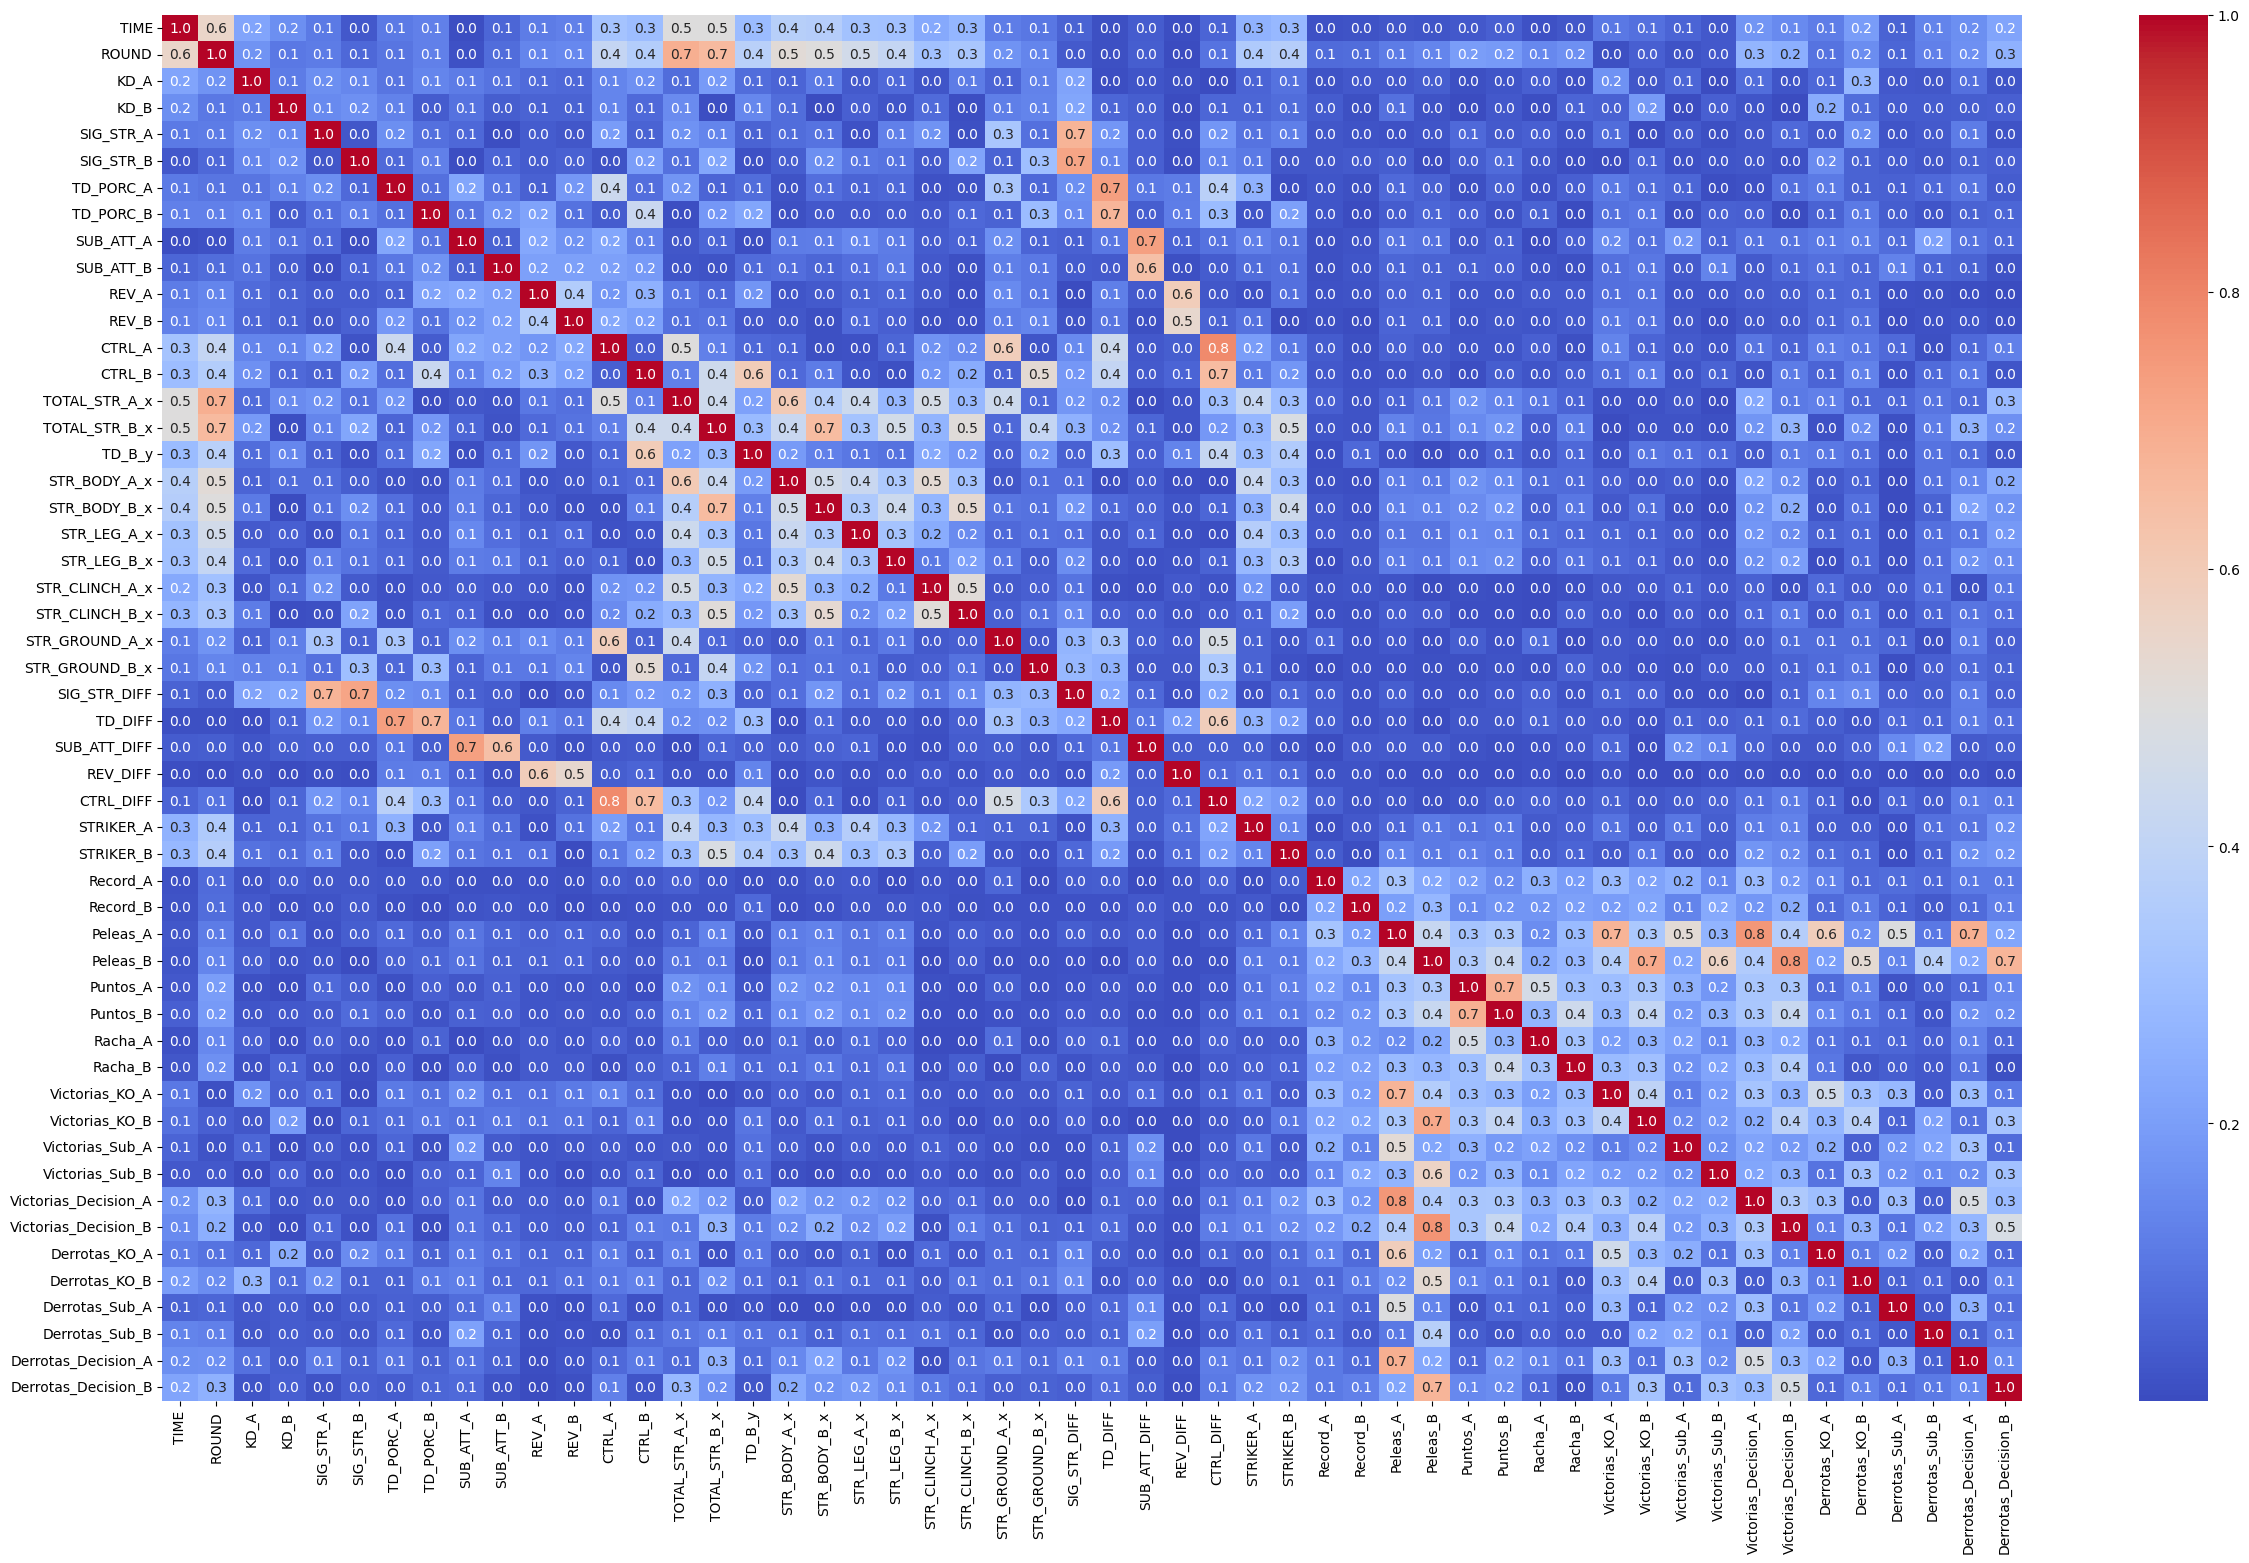

In [13]:
#Despues de eliminar correlaciones
plt.figure(figsize=(30, 18))
sns.heatmap(train_x2.corr().abs(), annot=True, cmap="coolwarm", fmt=".1f")
plt.show()

Se observa como ya no hay variables altamente correlacionadas entre si

*Transformaciones*

Para facilitar la convergencia del modelo, reducir los riesgos de sesgo y posteriormente poder comparar los coeficientes vamos a realizar un escalado robusto. Elegimos este tipo de escalado porque los datos no siguen distribuciones normales y tienen mucha presencia de datos atípicos. 

In [9]:
#Variables antes de la transformacion
train_x2.describe()

,TIME,KD_A,KD_B,SIG_STR_A,SIG_STR_B,TD_PORC_A,TD_PORC_B,SUB_ATT_A,SUB_ATT_B,REV_A,...,Victorias_Sub_A,Victorias_Sub_B,Victorias_Decision_A,Victorias_Decision_B,Derrotas_KO_A,Derrotas_KO_B,Derrotas_Sub_A,Derrotas_Sub_B,Derrotas_Decision_A,Derrotas_Decision_B
count,5490.000000,5490.000000,5490.000000,5490.000000,5490.000000,5490.000000,5490.000000,5490.000000,5490.000000,5490.00000,...,5490.000000,5490.000000,5490.000000,5490.000000,5490.000000,5490.000000,5490.000000,5490.000000,5490.000000,5490.000000
mean,227.611658,0.246995,0.185428,0.474093,0.435866,0.298880,0.231933,0.438069,0.333698,0.13898,...,0.976321,0.650273,2.124044,1.448816,0.781056,0.702732,0.502732,0.455191,1.334608,1.153916
std,92.425131,0.520849,0.458366,0.160498,0.170229,0.364121,0.336566,0.878214,0.777093,0.44418,...,1.552795,1.251017,2.281298,1.895720,1.149337,0.995971,0.924993,0.794575,1.629251,1.448386
min,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,154.000000,0.000000,0.000000,0.370000,0.330000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,293.000000,0.000000,0.000000,0.470000,0.430000,0.050000,0.000000,0.000000,0.000000,0.00000,...,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
75%,300.000000,0.000000,0.000000,0.570000,0.530000,0.500000,0.420000,1.000000,0.000000,0.00000,...,1.000000,1.000000,3.000000,2.000000,1.000000,1.000000,1.000000,1.000000,2.000000,2.000000
max,720.000000,5.000000,4.000000,1.000000,1.000000,1.000000,1.000000,10.000000,7.000000,6.00000,...,16.000000,14.000000,14.000000,13.000000,8.000000,8.000000,8.000000,6.000000,12.000000,12.000000


In [10]:
scaler = RobustScaler()
train_x3 = scaler.fit_transform(train_x2)
val_x3 = scaler.transform(val_x2)
test_x3 = scaler.transform(test_x2)

In [11]:
train_x3_df = pd.DataFrame(train_x3,columns=train_x2.columns)
val_x3_df = pd.DataFrame(val_x3,columns=val_x2.columns)
test_x3_df = pd.DataFrame(test_x3,columns=test_x2.columns)

#Variables despues de la transformacion
train_x3_df.describe()

,TIME,ROUND,KD_A,KD_B,SIG_STR_A,SIG_STR_B,TD_PORC_A,TD_PORC_B,SUB_ATT_A,SUB_ATT_B,...,Victorias_Sub_A,Victorias_Sub_B,Victorias_Decision_A,Victorias_Decision_B,Derrotas_KO_A,Derrotas_KO_B,Derrotas_Sub_A,Derrotas_Sub_B,Derrotas_Decision_A,Derrotas_Decision_B
count,5490.000000,5490.000000,5490.000000,5490.000000,5490.000000,5490.000000,5490.000000,5490.000000,5490.000000,5490.000000,...,5490.000000,5490.000000,5490.000000,5490.000000,5490.000000,5490.000000,5490.000000,5490.000000,5490.000000,5490.000000
mean,-0.447865,-0.310109,0.246995,0.185428,0.020464,0.029329,0.497760,0.552220,0.438069,0.333698,...,0.976321,0.650273,0.374681,0.224408,0.781056,0.702732,0.502732,0.455191,0.167304,0.076958
std,0.633049,0.503638,0.520849,0.458366,0.802490,0.851143,0.728242,0.801348,0.878214,0.777093,...,1.552795,1.251017,0.760433,0.947860,1.149337,0.995971,0.924993,0.794575,0.814625,0.724193
min,-1.972603,-1.000000,0.000000,0.000000,-2.350000,-2.150000,-0.100000,0.000000,0.000000,0.000000,...,0.000000,0.000000,-0.333333,-0.500000,0.000000,0.000000,0.000000,0.000000,-0.500000,-0.500000
25%,-0.952055,-1.000000,0.000000,0.000000,-0.500000,-0.500000,-0.100000,0.000000,0.000000,0.000000,...,0.000000,0.000000,-0.333333,-0.500000,0.000000,0.000000,0.000000,0.000000,-0.500000,-0.500000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.047945,0.000000,0.000000,0.000000,0.500000,0.500000,0.900000,1.000000,1.000000,0.000000,...,1.000000,1.000000,0.666667,0.500000,1.000000,1.000000,1.000000,1.000000,0.500000,0.500000
max,2.924658,1.000000,5.000000,4.000000,2.650000,2.850000,1.900000,2.380952,10.000000,7.000000,...,16.000000,14.000000,4.333333,6.000000,8.000000,8.000000,8.000000,6.000000,5.500000,5.500000


Realizo un RFECV (Recursive Feature Elimination with Cross-Validation) para seleccionar el número óptimo de variables.

In [12]:
def aplicarRFECV(X, Y):

    MIN_FEATURES=5
    
    # Modelo de regresión logística
    modelo = LogisticRegression(max_iter = 500, class_weight="balanced", random_state=42)

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
   
    rfecv = RFECV(
        estimator=modelo,
        step=1,
        cv=cv,
        scoring= "balanced_accuracy",
        min_features_to_select= MIN_FEATURES,
    )
    
    rfecv.fit(X,Y)
    
    num_optimal_features = rfecv.n_features_
    print("Número óptimo de variables seleccionadas:", num_optimal_features)

    #Obtengo índices de variables seleccionadas
    selected_feature_indices = rfecv.support_

    #Obtengo nombres de variables seleccionadas
    selected_feature_names = [X.columns[i] for i, selected in enumerate(selected_feature_indices) if selected]
    
    n_scores = len(rfecv.cv_results_["mean_test_score"])
    plt.figure(figsize=(12, 6))
    plt.xlabel("Número de variables elegidas")
    plt.ylabel("Media balanced accuracy en test")
    plt.errorbar(
        range(MIN_FEATURES, n_scores + MIN_FEATURES),
        rfecv.cv_results_["mean_test_score"],
        yerr=rfecv.cv_results_["std_test_score"],
    )
    plt.title("RFE con validación cruzada")
    plt.show()
    
    return selected_feature_names

Número óptimo de variables seleccionadas: 39


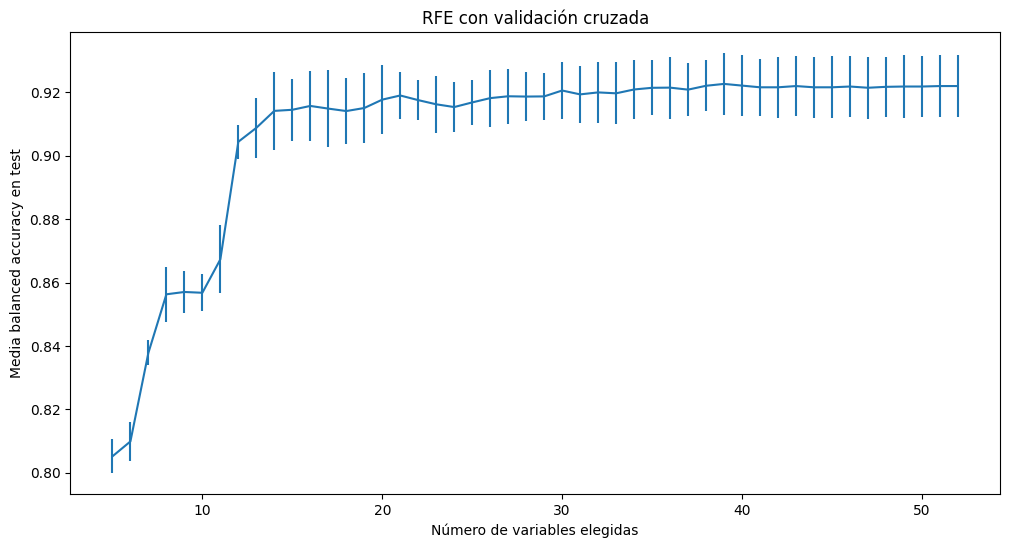

In [13]:
variablesElegidas = aplicarRFECV(train_x3_df, train_y)


In [14]:
variablesDescartadas = [v for v in train_x3_df.columns if v not in variablesElegidas]
print('Variables descartadas: ',variablesDescartadas)
print('Variables elegidas: ',variablesElegidas)

Variables descartadas:  ['TIME', 'SIG_STR_A', 'SUB_ATT_B', 'REV_A', 'CTRL_B', 'TD_B_y', 'STR_BODY_B_x', 'STR_LEG_A_x', 'STR_LEG_B_x', 'STR_CLINCH_A_x', 'STR_CLINCH_B_x', 'Victorias_KO_B', 'Victorias_Sub_B']
Variables elegidas:  ['ROUND', 'KD_A', 'KD_B', 'SIG_STR_B', 'TD_PORC_A', 'TD_PORC_B', 'SUB_ATT_A', 'REV_B', 'CTRL_A', 'TOTAL_STR_A_x', 'TOTAL_STR_B_x', 'STR_BODY_A_x', 'STR_GROUND_A_x', 'STR_GROUND_B_x', 'SIG_STR_DIFF', 'TD_DIFF', 'SUB_ATT_DIFF', 'REV_DIFF', 'CTRL_DIFF', 'STRIKER_A', 'STRIKER_B', 'Record_A', 'Record_B', 'Peleas_A', 'Peleas_B', 'Puntos_A', 'Puntos_B', 'Racha_A', 'Racha_B', 'Victorias_KO_A', 'Victorias_Sub_A', 'Victorias_Decision_A', 'Victorias_Decision_B', 'Derrotas_KO_A', 'Derrotas_KO_B', 'Derrotas_Sub_A', 'Derrotas_Sub_B', 'Derrotas_Decision_A', 'Derrotas_Decision_B']


In [16]:
train_x4=train_x3_df.drop(columns=variablesDescartadas)
val_x4=val_x3_df.drop(columns=variablesDescartadas)
test_x4=test_x3_df.drop(columns=variablesDescartadas)

*Ajuste de hiperparametros*

Medinate busqueda en rejilla y validacion cruzada

In [36]:
f1_scorer = make_scorer(f1_score, average='macro')

def realizarRandomizedSearchCV(estimador, param, kf, X, Y):
    """Realiza la estrategia de búsqueda Grid Search CV"""

    randomized_search = RandomizedSearchCV(estimator=estimador, param_distributions=param, cv=kf,
                            scoring=f1_scorer, refit = "balanced_accuracy", return_train_score=True, n_jobs=-1, error_score="raise")

    randomized_search.fit(X, Y)
    
    return randomized_search


Medinate en rejilla y validacion cruzada

In [37]:
def realizarGridSearchCV(estimador, param, kf, X, Y):
    """Realiza la estrategia de búsqueda Grid Search CV"""

    grid_search = GridSearchCV(estimator=estimador, param_grid=param, cv=kf,
                            scoring=f1_scorer, refit = "balanced_accuracy", return_train_score=True, n_jobs=-1, error_score="raise")

    grid_search.fit(X, Y)
    
    return grid_search

In [38]:
# Cuadrícula de hiperparámetros
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_y), y=train_y)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}
param_grid = {
        'C': [0.01, 0.1, 1, 10, 100,1000,10000],
        'penalty': ['elasticnet'],
        'solver': ['saga'],
        'class_weight': [None, class_weight_dict],
        'l1_ratio': np.linspace(0.0, 1.0, 10),
    }

param_distributions = {
    'C': uniform(0.01, 10000),  # Toma valores aleatorios entre 0.01 y 10000
    'penalty': ['elasticnet'],
    'solver': ['saga'],
    'class_weight': [None, class_weight_dict],
    'l1_ratio': uniform(0.0, 1.0),  # Valores aleatorios entre 0 y 1
}

modelo = LogisticRegression(random_state=42, max_iter=500)

grid_search = realizarGridSearchCV(modelo, param_grid, 5, train_x4, train_y)

modelo_final_grid = grid_search.best_estimator_
cv_results_grid = grid_search.cv_results_
best_params_grid = grid_search.best_params_

random_search = realizarRandomizedSearchCV(modelo, param_distributions, 5, train_x4, train_y)

modelo_final_random = random_search.best_estimator_
cv_results_random = random_search.cv_results_
best_params_random = random_search.best_params_

c:\Users\Mario\Documents\GitHub\c2425-R4\.venv\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Mario\Documents\GitHub\c2425-R4\.venv\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


*Evaluacion del modelo*

In [39]:
def evaluarModelo(modelo,val_x,val_y):
    # Predicciones
    val_y_pred = modelo.predict(val_x)  # Predicción de clases
    val_y_prob = modelo.predict_proba(val_x)[:, 1]  # Probabilidad de la clase positiva

    # Cálculo de métricas
    accuracy = accuracy_score(val_y, val_y_pred)
    f1_val = f1_score(val_y, val_y_pred)
    roc_auc_val = roc_auc_score(val_y, val_y_prob)
    precision_val = precision_score(val_y, val_y_pred)
    recall_val = recall_score(val_y, val_y_pred)
    log_loss_val = log_loss(val_y, val_y_prob)

        # Imprimir métricas
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1-Score: {f1_val:.4f}")
    print(f"AUC-ROC: {roc_auc_val:.4f}")
    print(f"Precisión: {precision_val:.4f}")
    print(f"Sensibilidad (Recall): {recall_val:.4f}")
    print(f"Log-loss: {log_loss_val:.4f}")
    # Calcular la matriz de confusión
    cm = confusion_matrix(val_y, val_y_pred)

    # Visualizar la matriz de confusión
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Clase 0', 'Clase 1'], yticklabels=['Clase 0', 'Clase 1'])
    plt.xlabel('Predicción')
    plt.ylabel('Real')
    plt.title('Matriz de Confusión')
    plt.show()


-- Métricas del modelo con hiperparámetros ajustados mediante GridSearchCV --
Accuracy: 0.9244
F1-Score: 0.9013
AUC-ROC: 0.9758
Precisión: 0.8781
Sensibilidad (Recall): 0.9257
Log-loss: 0.1982


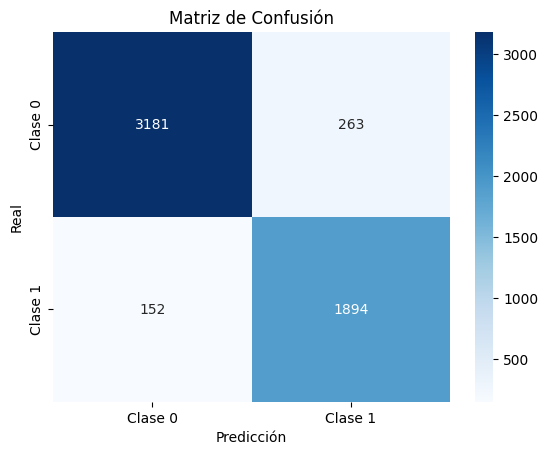

In [40]:
print("\n-- Métricas del modelo con hiperparámetros ajustados mediante GridSearchCV --")
evaluarModelo(modelo_final_grid,val_x4,val_y)


-- Métricas del modelo con hiperparámetros ajustados mediante RandomizedSearchCV --
Accuracy: 0.9268
F1-Score: 0.9014
AUC-ROC: 0.9758
Precisión: 0.9045
Sensibilidad (Recall): 0.8983
Log-loss: 0.1901


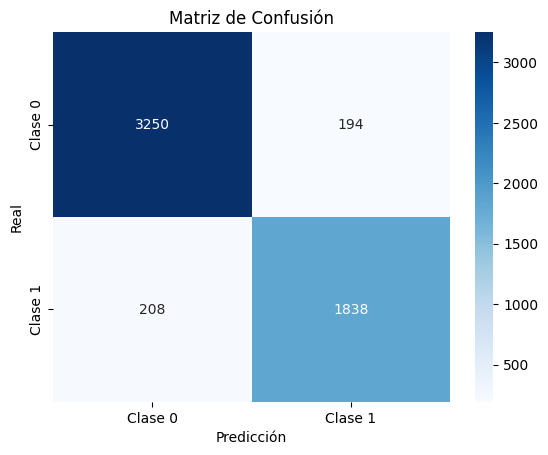

In [41]:
print("\n-- Métricas del modelo con hiperparámetros ajustados mediante RandomizedSearchCV --")
evaluarModelo(modelo_final_random,val_x4,val_y)

Se observan resultandos similares con busqueda aletoria y con busqueda en rejilla, por ello es más eficiente la busqueda aleatoria ya que lleva un tiempo de ejecución significativamente inferior.